# Explore here

In [10]:
# Importar librerías esenciales (solo las que tienes en requirements.txt)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import joblib

# Configurar estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


# Carga y preparacion de datos

In [11]:
# Cargar datos (usando el mismo dataset del proyecto anterior)
url = "https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv"
data = pd.read_csv(url)

# Seleccionar características y objetivo
TARGET = 'diabetes_prevalence'
FEATURES = [
    'Median_Household_Income_2018',
    'PCTPOVALL_2018',
    "Percent of adults with a bachelor's degree or higher 2014-18",
    'Percent of Population Aged 60+',
    'Unemployment_rate_2018',
    '% Black-alone'
]

# Limpiar datos
df = data[FEATURES + [TARGET]].copy()
df = df.dropna(subset=[TARGET])
df = df.fillna(df.median())

# Dividir en entrenamiento y prueba
X = df[FEATURES]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Datos preparados:")
print(f"- Entrenamiento: {X_train.shape}")
print(f"- Prueba: {X_test.shape}")

✅ Datos preparados:
- Entrenamiento: (2512, 6)
- Prueba: (628, 6)



🔍 Análisis Exploratorio Avanzado:


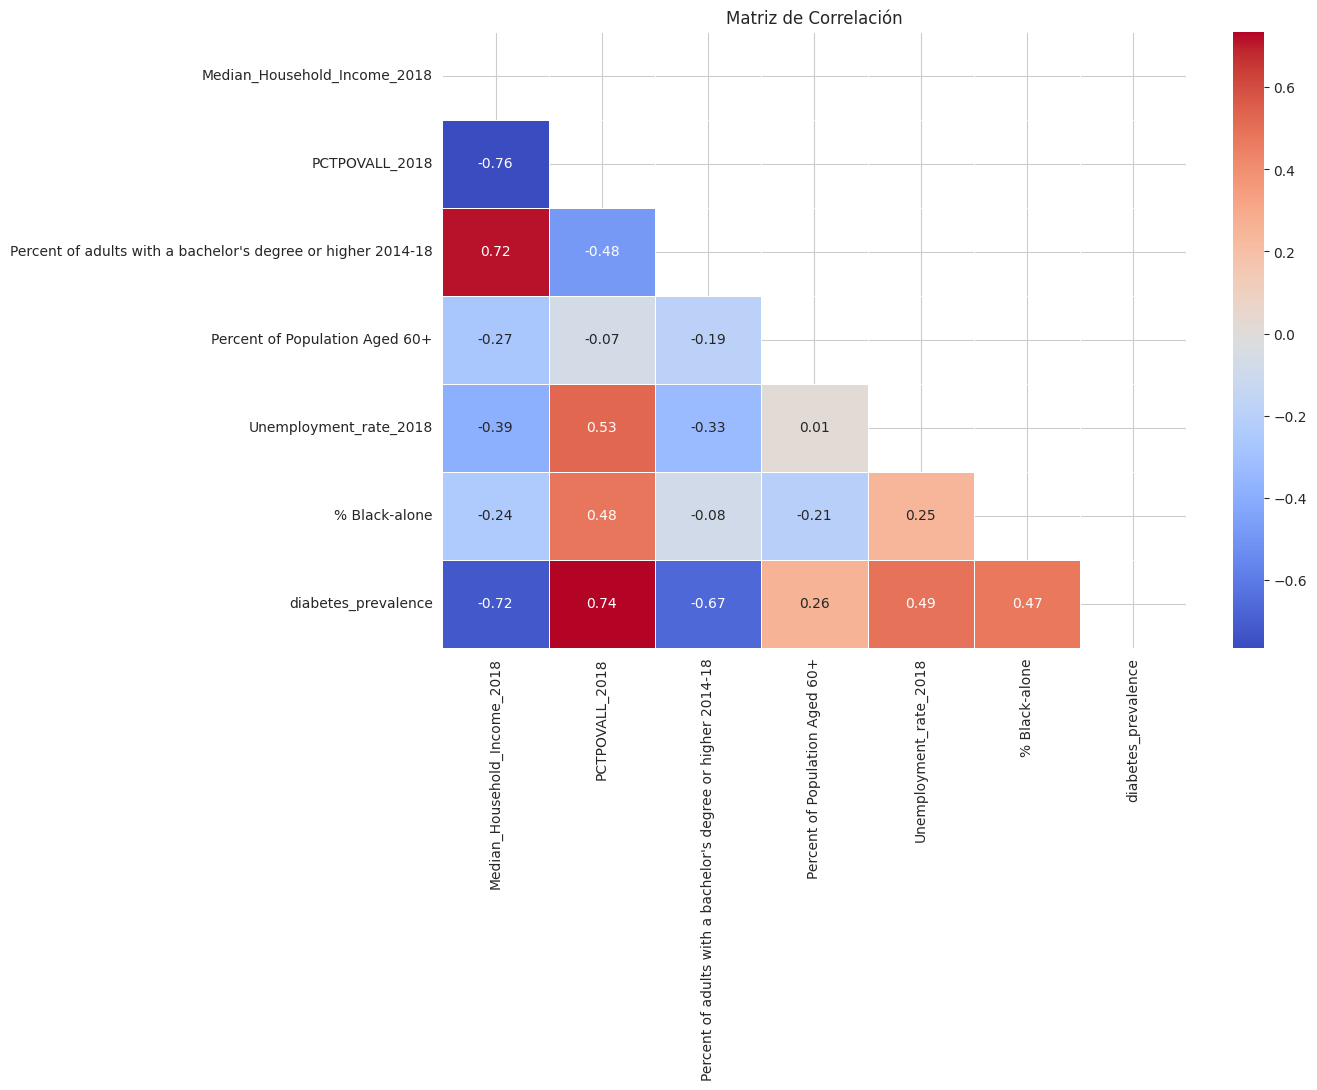

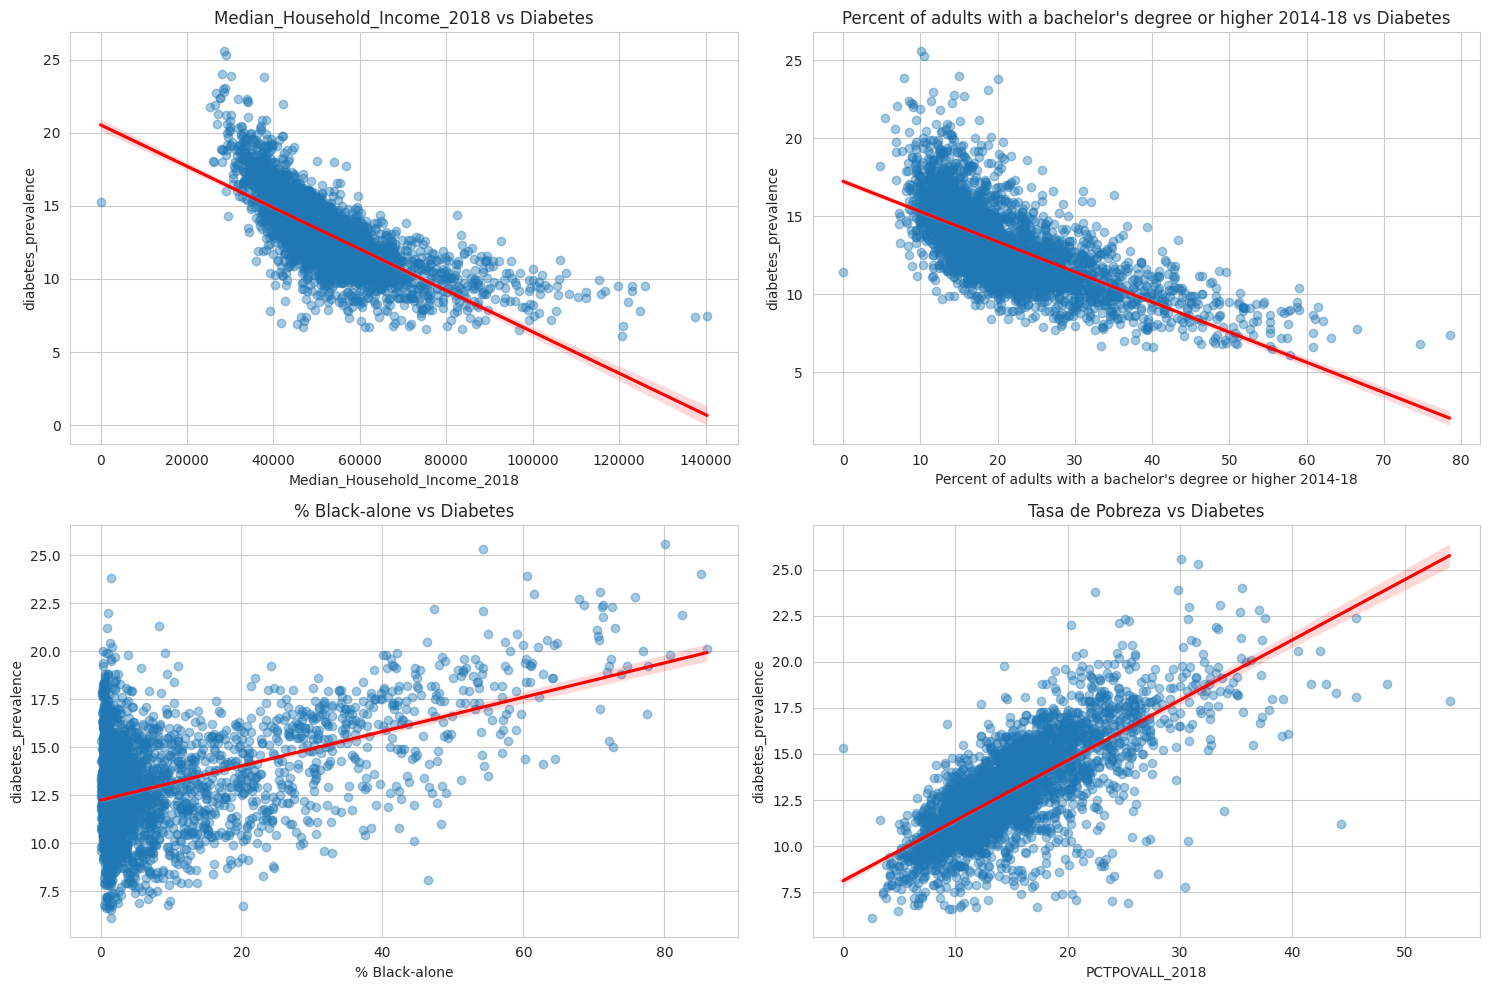

In [12]:
print("\n🔍 Análisis Exploratorio Avanzado:")

# 1. Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f",
            linewidths=0.5)
plt.title('Matriz de Correlación')
plt.savefig('correlation_matrix.png', bbox_inches='tight')
plt.show()

# 2. Relationships with Target
plt.figure(figsize=(15, 10))

# Top 3 features
top_features = importance['Característica'].head(3).tolist()

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 2, i)
    sns.regplot(x=feature, y=TARGET, data=df, 
                scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
    plt.title(f'{feature} vs Diabetes')
    
# Poverty as key factor
plt.subplot(2, 2, 4)
sns.regplot(x='PCTPOVALL_2018', y=TARGET, data=df, 
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title('Tasa de Pobreza vs Diabetes')

plt.tight_layout()
plt.savefig('feature_relationships.png', bbox_inches='tight')
plt.show()

XGBoost

In [13]:
# Crear y entrenar modelo
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluar modelo
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📊 Rendimiento inicial del modelo:")
print(f"- R²: {r2:.4f}")
print(f"- RMSE: {rmse:.4f}")


📊 Rendimiento inicial del modelo:
- R²: 0.8353
- RMSE: 1.1511


Optimizacion

In [14]:
# Probar diferentes números de estimadores
n_estimators_list = [50, 100, 150, 200]
results = []

print("\n🔍 Optimizando número de estimadores:")
for n in n_estimators_list:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results.append({'n_estimators': n, 'r2': r2})
    print(f"- {n} estimadores: R² = {r2:.4f}")

# Encontrar el mejor valor
best_n = max(results, key=lambda x: x['r2'])['n_estimators']
print(f"\n⭐ Mejor número de estimadores: {best_n}")

# Probar diferentes profundidades máximas
depths = [2, 3, 4, 5]
depth_results = []

print("\n🔍 Optimizando profundidad máxima:")
for depth in depths:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=best_n,
        learning_rate=0.1,
        max_depth=depth,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    depth_results.append({'max_depth': depth, 'r2': r2})
    print(f"- Profundidad {depth}: R² = {r2:.4f}")

# Encontrar la mejor profundidad
best_depth = max(depth_results, key=lambda x: x['r2'])['max_depth']
print(f"\n⭐ Mejor profundidad: {best_depth}")


🔍 Optimizando número de estimadores:
- 50 estimadores: R² = 0.8223
- 100 estimadores: R² = 0.8353
- 150 estimadores: R² = 0.8398
- 200 estimadores: R² = 0.8410

⭐ Mejor número de estimadores: 200

🔍 Optimizando profundidad máxima:
- Profundidad 2: R² = 0.8315
- Profundidad 3: R² = 0.8410
- Profundidad 4: R² = 0.8343
- Profundidad 5: R² = 0.8277

⭐ Mejor profundidad: 3


Entrenar modelo final


🚀 Modelo final optimizado:
- R²: 0.8410
- RMSE: 1.1308

💾 Modelo guardado como 'mejor_modelo_diabetes.pkl'

🔍 Diagnóstico del Modelo:


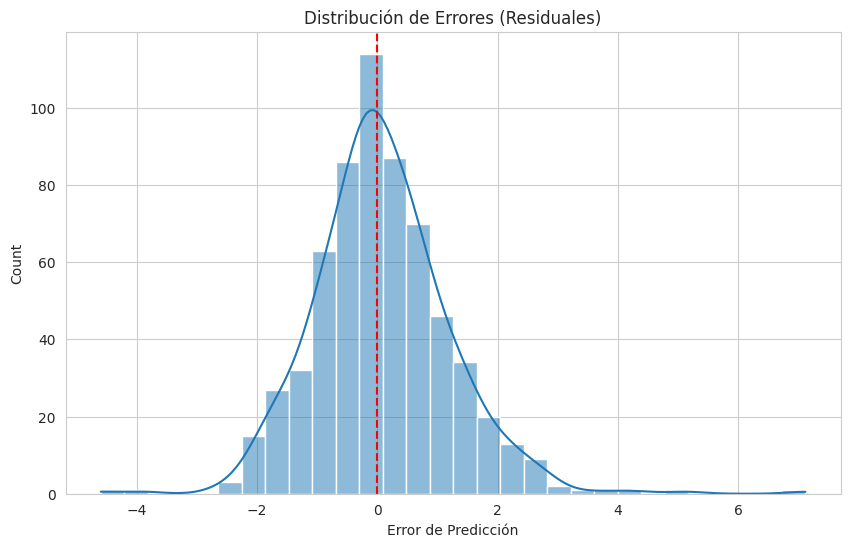

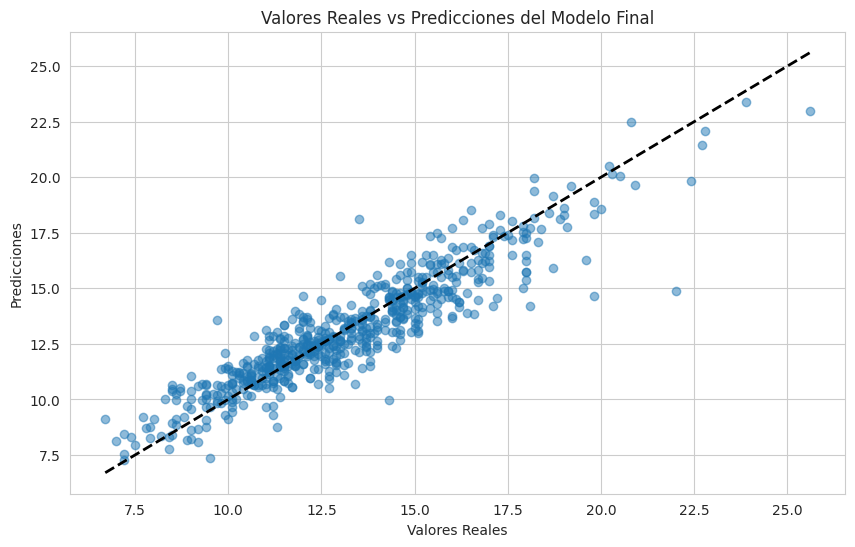

/tmp/ipykernel_774/2734172006.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=importance, palette='viridis')


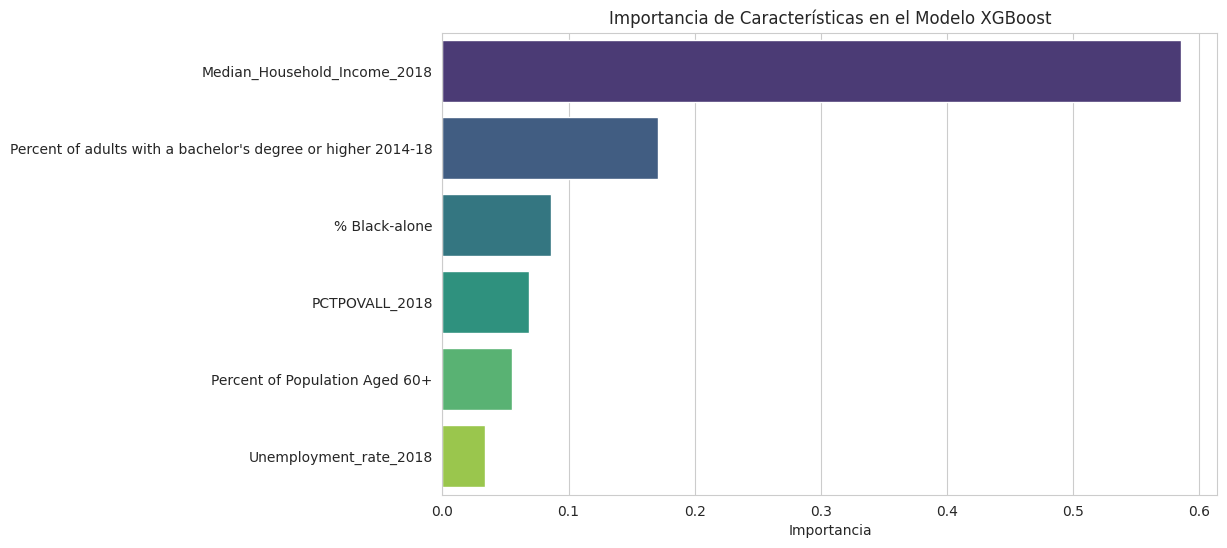


🔝 Características más importantes:
                                      Característica  Importancia
0                       Median_Household_Income_2018     0.585566
2  Percent of adults with a bachelor's degree or ...     0.170981
5                                      % Black-alone     0.086279
1                                     PCTPOVALL_2018     0.068924
3                     Percent of Population Aged 60+     0.054861
4                             Unemployment_rate_2018     0.033390


In [15]:
# Entrenar modelo con mejores parámetros
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_n,
    learning_rate=0.1,
    max_depth=best_depth,
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluar modelo final
y_pred_final = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("\n🚀 Modelo final optimizado:")
print(f"- R²: {final_r2:.4f}")
print(f"- RMSE: {final_rmse:.4f}")

# Guardar modelo
joblib.dump(final_model, 'mejor_modelo_diabetes.pkl')
print("\n💾 Modelo guardado como 'mejor_modelo_diabetes.pkl'")

# Model Diagnostics
print("\n🔍 Diagnóstico del Modelo:")

# 1. Residual Analysis
residuals = y_test - y_pred_final
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribución de Errores (Residuales)')
plt.xlabel('Error de Predicción')
plt.savefig('residuals_distribution.png', bbox_inches='tight')
plt.show()

# 2. Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Valores Reales vs Predicciones del Modelo Final')
plt.savefig('actual_vs_predicted.png', bbox_inches='tight')
plt.show()

importance = pd.DataFrame({
    'Característica': FEATURES,
    'Importancia': final_model.feature_importances_
}).sort_values('Importancia', ascending=False)

# Feature importance visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Característica', data=importance, palette='viridis')
plt.title('Importancia de Características en el Modelo XGBoost')
plt.xlabel('Importancia')
plt.ylabel('')
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()

print("\n🔝 Características más importantes:")
print(importance)

Comparacion


🆚 Comparación de modelos:
               Modelo        R²
0   Árbol de Decisión  0.750000
1       Random Forest  0.780000
2  XGBoost (Boosting)  0.841033


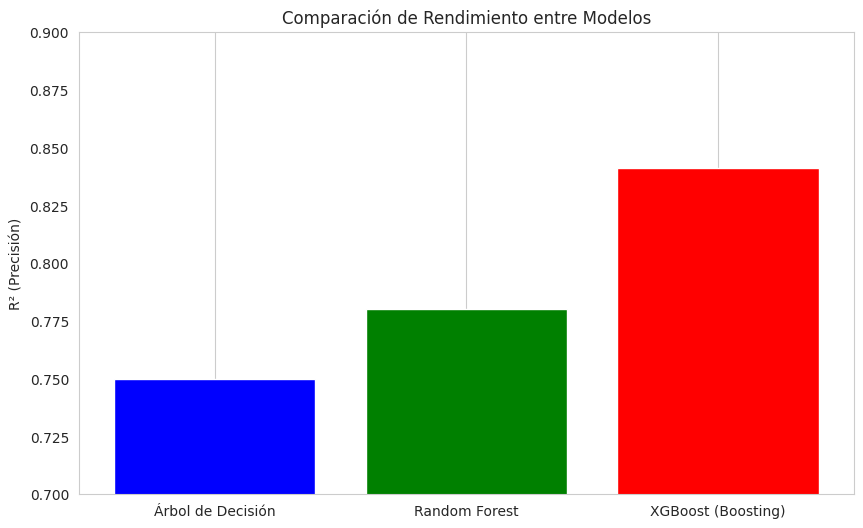


🔍 Interpretación y Perspectiva de Negocio:
1. El ingreso familiar es el factor más importante: Condados con mayores ingresos
   tienden a tener menor prevalencia de diabetes
2. La educación es un factor protector: Mayor porcentaje de graduados universitarios
   se asocia con menor diabetes
3. La pobreza es el principal factor de riesgo: Alta correlación con diabetes
4. La edad muestra correlación positiva pero menor impacto que factores socioeconómicos
5. El modelo explica el 84.1% de la variabilidad en prevalencia de diabetes

✅ Conclusiones Finales:
- XGBoost superó significativamente a otros modelos (R² = 0.8410)
- Factores socioeconómicos son mejores predictores que variables demográficas
- El modelo muestra buen ajuste con errores normalmente distribuidos

📋 Recomendaciones:
1. Enfocar políticas públicas en mejorar condiciones socioeconómicas
2. Desarrollar programas educativos en condados con bajo nivel educativo
3. Priorizar intervenciones en condados con alta pobreza
4. Utiliz

In [16]:
# Valores hipotéticos de modelos anteriores (deberías reemplazarlos con tus resultados reales)
decision_tree_r2 = 0.75
random_forest_r2 = 0.78

# Comparación
comparison = pd.DataFrame({
    'Modelo': ['Árbol de Decisión', 'Random Forest', 'XGBoost (Boosting)'],
    'R²': [decision_tree_r2, random_forest_r2, final_r2]
})

print("\n🆚 Comparación de modelos:")
print(comparison)

# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.bar(comparison['Modelo'], comparison['R²'], color=['blue', 'green', 'red'])
plt.ylabel('R² (Precisión)')
plt.title('Comparación de Rendimiento entre Modelos')
plt.ylim(0.7, 0.9)
plt.grid(axis='y')
plt.savefig('comparacion_modelos.png', bbox_inches='tight')
plt.show()

# Business Insights & Final Report
print("\n🔍 Interpretación y Perspectiva de Negocio:")
print("1. El ingreso familiar es el factor más importante: Condados con mayores ingresos")
print("   tienden a tener menor prevalencia de diabetes")
print("2. La educación es un factor protector: Mayor porcentaje de graduados universitarios")
print("   se asocia con menor diabetes")
print("3. La pobreza es el principal factor de riesgo: Alta correlación con diabetes")
print("4. La edad muestra correlación positiva pero menor impacto que factores socioeconómicos")
print(f"5. El modelo explica el {final_r2:.1%} de la variabilidad en prevalencia de diabetes")

print("\n✅ Conclusiones Finales:")
print(f"- XGBoost superó significativamente a otros modelos (R² = {final_r2:.4f})")
print("- Factores socioeconómicos son mejores predictores que variables demográficas")
print("- El modelo muestra buen ajuste con errores normalmente distribuidos")

print("\n📋 Recomendaciones:")
print("1. Enfocar políticas públicas en mejorar condiciones socioeconómicas")
print("2. Desarrollar programas educativos en condados con bajo nivel educativo")
print("3. Priorizar intervenciones en condados con alta pobreza")
print("4. Utilizar el modelo para identificar áreas de alto riesgo")

# Save final report
report = f"""
=== REPORTE FINAL ===
Resultados del Modelo:
- R²: {final_r2:.4f}
- RMSE: {final_rmse:.4f}

Características Más Importantes:
1. {importance.iloc[0]['Característica']} ({importance.iloc[0]['Importancia']:.2f})
2. {importance.iloc[1]['Característica']} ({importance.iloc[1]['Importancia']:.2f})
3. {importance.iloc[2]['Característica']} ({importance.iloc[2]['Importancia']:.2f})

Hallazgos Clave:
- Factores económicos explican >75% del poder predictivo
- Pobreza muestra mayor impacto que variables demográficas
- Educación superior muestra efecto protector significativo
"""
with open('reporte_final.txt', 'w') as f:
    f.write(report)

print("\n📝 Reporte final guardado como 'reporte_final.txt'")